# 5TF078 Deep Learning Course
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-03-23 First revision based on earlier excercises /ToNo
* 2022-03-30 Adjusted the Keras Tuner search to reduce compute times. /Tomas
* 2022-04-05 Added padding='same' as an argument to Conv2D. /Tomas
* 2022-05-09 Swaped optimizer to use 'adam' as default and 'sgd' as extra test. /Tomas
* 2022-05-09 Fixed so that we can use the latest version (1.1.2) of keras tuner. /Tomas
* 2022-11-07 Added hints to use incremental model definitions when we want to have varying number of layers with Keras tuner. /Tomas
* 2022-11-09 Updated check for colab to NOT use env. var. COLAB_GPU as it has gone missing. /Tomas
* 2023-10-22 - Update keras imports to prepare for Keras 3.0 /Tomas
* 2023-11-06 - Updated references to Geron from edition 2 to edition 3 /Tomas
* 2023-11-13 - Fixed which set of parameters to extract via get_best_hyperparameters. /Tomas
* 2024-03-24 - Updated tests for Kaggle. /Tomas

## **Erik Vodopivec Forsman**

# First we initilize our Python environment

In [1]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils  import to_categorical

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [2]:
import sys

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [3]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-11acf690-c4ac-3906-9c24-5998ffabd725)


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [6]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) :
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) :
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) :
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes!

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [8]:
# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: Shirt


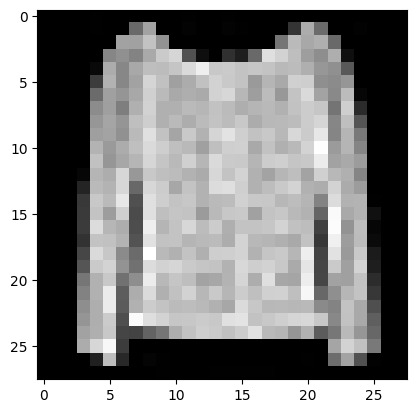

Label: Coat


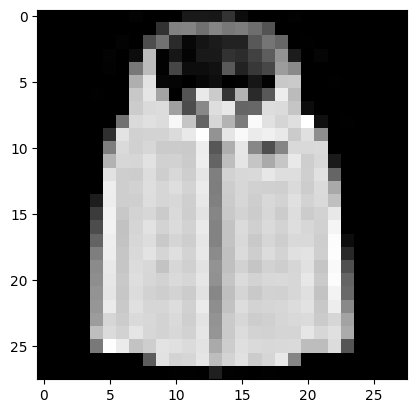

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(np.squeeze(train_images[index], axis=-1))
  plt.gray()
  plt.grid(False)
  plt.show(block=False)

# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a starting point. A good modell is expected to have 5-50 times as many parameters!

In [9]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=16, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 16)                200720    
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 201050 (785.35 KB)
Trainable params: 201050 (785.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

# Run the training

In [ ]:
epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15
1500/1500 [==============================] - 18s 11ms/step - loss: 0.5154 - categorical_accuracy: 0.8193 - val_loss: 0.4373 - val_categorical_accuracy: 0.8487
Epoch 2/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3379 - categorical_accuracy: 0.8793 - val_loss: 0.3361 - val_categorical_accuracy: 0.8850
Epoch 3/15
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2925 - categorical_accuracy: 0.8949 - val_loss: 0.3061 - val_categorical_accuracy: 0.8948
Epoch 4/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2627 - categorical_accuracy: 0.9065 - val_loss: 0.3036 - val_categorical_accuracy: 0.8926
Epoch 5/15
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2390 - categorical_accuracy: 0.9120 - val_loss: 0.2825 - val_categorical_accuracy: 0.9035
Epoch 6/15
1500/1500 [==============================] - 17s 12ms/step - loss: 0.2178 - categorical_accuracy: 0.9210 - val_loss: 0.3020 - val_categoric

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

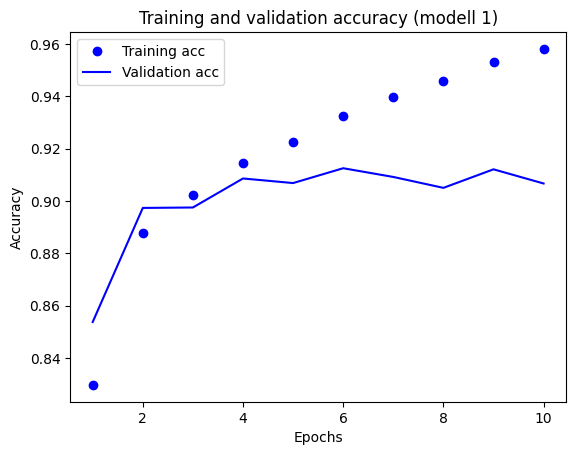

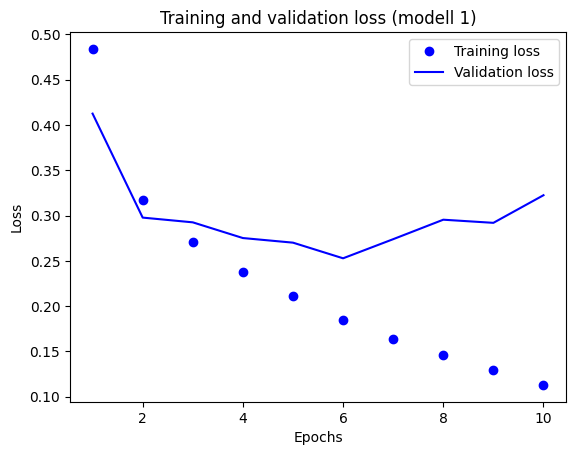

In [ ]:
epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notera hur träningsnoggrannheten konstant går uppåt (och träningsförlusten nedåt). Medan valideringsförlusten bottnar ut någonstans mellan 5-10 epochs för att sedan långsamt går uppåt. Detta tyder på en svag överträning, om förlusten hade fortsatt nedåt tillsammans med träningsförlusten hade modellen fortfarande varit undertränad. Men överlag kan vi misstänka att modellens kapacitet vid 15 epochs är det bästa som denna modell kan åstadkomma.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 3s 8ms/step - loss: 0.3421 - categorical_accuracy: 0.8952
Test accuracy: 0.895


# Övning Del 1a
## Frågor att besvara:
* Hur många parametrar har din modell? \
Svar: 306386 (total mängd parametrar)
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.) \
Svar: 0.895 (ca.)
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad, vad i träningskurvorna kan avgöra det? \
Svar: Den är smått övertränad efterom valideringsförlusten börjar gå uppåt igen.
* Hur många epochs skulle ha varit lämpligt att använda? \
Svar: Ca. 8 (inte mindre än 5 och inte fler än 10)

# Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen). Notera att man gärna har med MaxPooling2D-lager mellan varje eller varannat faltningslager, då det hjälper med att hålla ner antalet parametrar vilket även leder till snabbare och ofta bättre träningsresultat (ger tex en viss extra translations och skalinvarians). Detta är speciellt viktigt om man har stora inbilder, men kan nog ge bra effekt även på våra minimala bilder.

Målet är att få modellen att bli komplex nog att väl kunna representera data. En viss överträning är OK, vi ska ju sedan åtgärda det med regularisering.
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då?
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där valideringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.

In [ ]:
# Kod för din bästa modell och dess träning och utvärdering

input_shape = test_images[0].shape
print("Input shape", input_shape)

model = Sequential([

# First conv. layer with kernel size 5, 5 and the other 2 with kernel size 3, 3
# First Convolutional Layer
Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
# Second Convolutional Layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
# Third Convolutional Layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input.
Flatten(),

# Hidden Dense layer
Dense(units=36, activation='relu'),

# Output layer
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 28, 28, 16)        416       
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 flatten_18 (Flatten)        (None, 12544)             0         
                                                                 
 dense_34 (Dense)            (None, 36)                451620    
                                                                 
 dense_35 (Dense)            (None, 10)                370       
                                                                 
Total params: 457046 (1.74 MB

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

In [ ]:
epochs = 5      ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/5
 104/1500 [=>............................] - ETA: 1:01 - loss: 0.4667 - categorical_accuracy: 0.8323

KeyboardInterrupt: 

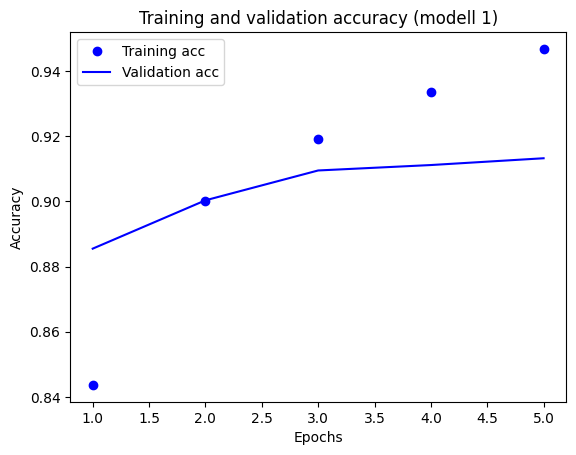

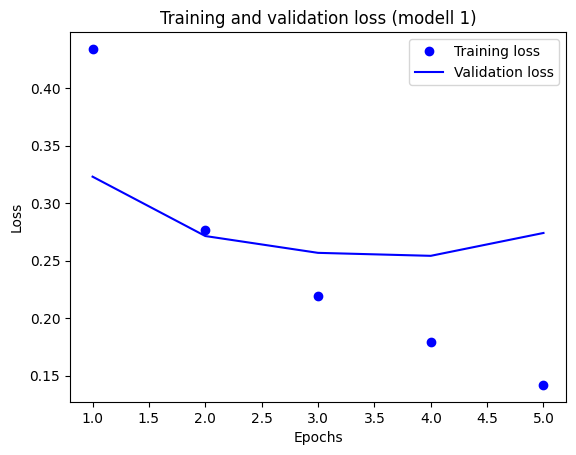

In [ ]:
epochrange = range(1, epochs + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 6s 18ms/step - loss: 0.2897 - categorical_accuracy: 0.9089
Test accuracy: 0.909


## Analys
Dokumentera dina experiment, med modellkonfiguration, testnoggrannhet, och vid vilken epoch modellen börjar överträna.
* Gör en sammanfattande analys av dina experiment hittills.

* Testade med 2 faltningslager och 10 epocher. Fick en del överträning. Kör nästa test med 8 epocher. Ändrade faltiningslager 1 till 5x5.
* Övertränades inte, men ej förbättrade resultat i förhållande till originalmodellen. Tastar att ha båda lagren 3x3.
* Liten försämring pga övertäning med båda lagren på 3x3. Återgår till att ha första lagrewt 5x5 och testar med 3 faltningslager i nästa körning.
* Bättre recultat men en del överträning. Går ner till 7 epochedr i nästa körning.
* Fortfarande en del överträning. Går ner till 6 epocher och ökar units till 24.
* Övertränas men möjligheter till bra resultat med färre epochs. Minskar till 3 epochs.
* Gav bättre resultat utan överträning. Testar 36 units i nästa test.
* Behövs fler epochs. Ökar till 5.
* Detta gav en testnogrannhet på ca. 0.909 (jämför med 0.89 från början). Hade en lite högre "loss" i sista epochen jämfört med den näst sista.

# Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [Se Geron s. 162 för "Early Stopping"]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


In [10]:
# Kod där du inför avbruten träning

input_shape = test_images[0].shape
print("Input shape", input_shape)

model = Sequential([

# First Convolutional Layer
Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
# Second Convolutional Layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
# Third Convolutional Layer
 Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input
Flatten(),

# Hidden Dense layer
Dense(units=36, activation='relu'),

# Output layer
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        416       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 36)                451620    
                                                                 
 dense_3 (Dense)             (None, 10)                370       
                                                                 
Total params: 457046 (1.74 MB)

In [11]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

In [12]:
epochs = 20      ## Number of epoch to run
batch_size = 32  ## Mini batch size
es=keras.callbacks.EarlyStopping('val_loss', patience=4, restore_best_weights = True) #Early stopping callback

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[es],
)





Epoch 1/20
1500/1500 [==============================] - 20s 9ms/step - loss: 0.4716 - categorical_accuracy: 0.8332 - val_loss: 0.3201 - val_categorical_accuracy: 0.8851
Epoch 2/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2925 - categorical_accuracy: 0.8947 - val_loss: 0.2680 - val_categorical_accuracy: 0.9035
Epoch 3/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2380 - categorical_accuracy: 0.9135 - val_loss: 0.2494 - val_categorical_accuracy: 0.9128
Epoch 4/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2019 - categorical_accuracy: 0.9268 - val_loss: 0.2618 - val_categorical_accuracy: 0.9090
Epoch 5/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1694 - categorical_accuracy: 0.9386 - val_loss: 0.2521 - val_categorical_accuracy: 0.9130
Epoch 6/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1452 - categorical_accuracy: 0.9467 - val_loss: 0.2558 - val_categorical_accurac

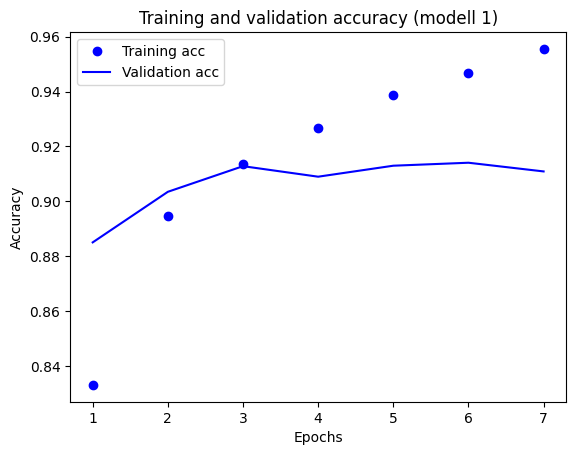

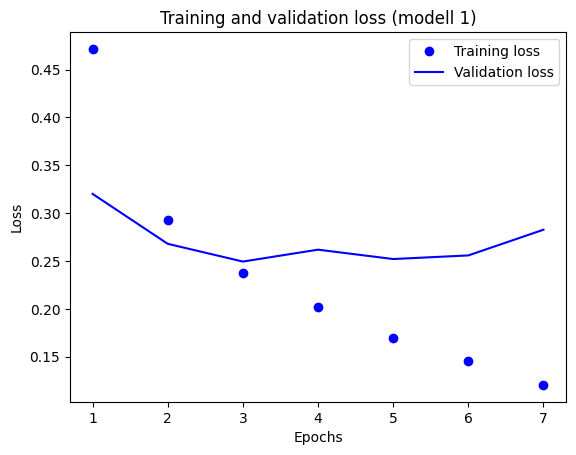

In [13]:
epoch_es = es.stopped_epoch + 1 # Gör så att plotting fungerar även med early stopping
epochrange = range(1, epoch_es + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 3s 10ms/step - loss: 0.2744 - categorical_accuracy: 0.8971
Test accuracy: 0.897


## Analys
Vid vilken Epoch stannar nu träningen? \
Svar: 7 (vid patience 4) \
Ändras nu modellens testnoggrannhet då den inte övertränar? \
Svar: Nej. Det är ungefär samma eller lite sämre. Jag valde mängden epochs i uppgift 1 efter bästa nogrannhet (early stopping baserar detsamma på validation loss). Detta gör att även om noggrannheten är ungefär samma så är förlusten mindre.

# Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering. Analysera och jämför dessa modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [Se Geron s. 367 för "Batch Normalization"; s 392.. "Avoiding Overfitting Through Regularization"]

In [ ]:
# Kod där du inför regularisering

input_shape = test_images[0].shape
print("Input shape", input_shape)

model = Sequential([

# Add a convolution layer
Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=36, activation='relu'),

keras.layers.BatchNormalization(),  #Batch normalization layer

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        416       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                                 
 dense_6 (Dense)             (None, 36)                451620    
                                                                 
 batch_normalization_2 (Bat  (None, 36)                144       
 chNormalization)                                                
                              

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

In [ ]:
epochs = 20      ## Number of epoch to run
batch_size = 32  ## Mini batch size
es=keras.callbacks.EarlyStopping('val_loss', patience=4, restore_best_weights = True) #Early stopping callback

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[es],
)

Epoch 1/20
1500/1500 [==============================] - 103s 68ms/step - loss: 0.3992 - categorical_accuracy: 0.8600 - val_loss: 0.3102 - val_categorical_accuracy: 0.8895
Epoch 2/20
1500/1500 [==============================] - 96s 64ms/step - loss: 0.2675 - categorical_accuracy: 0.9039 - val_loss: 0.2754 - val_categorical_accuracy: 0.9053
Epoch 3/20
1500/1500 [==============================] - 101s 67ms/step - loss: 0.2147 - categorical_accuracy: 0.9226 - val_loss: 0.2744 - val_categorical_accuracy: 0.9011
Epoch 4/20
1500/1500 [==============================] - 104s 70ms/step - loss: 0.1760 - categorical_accuracy: 0.9363 - val_loss: 0.2515 - val_categorical_accuracy: 0.9151
Epoch 5/20
1500/1500 [==============================] - 118s 78ms/step - loss: 0.1447 - categorical_accuracy: 0.9477 - val_loss: 0.3074 - val_categorical_accuracy: 0.9037
Epoch 6/20
1500/1500 [==============================] - 98s 65ms/step - loss: 0.1147 - categorical_accuracy: 0.9572 - val_loss: 0.2995 - val_categ

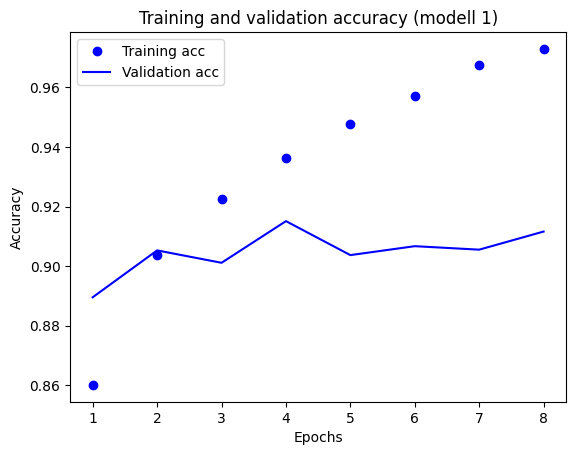

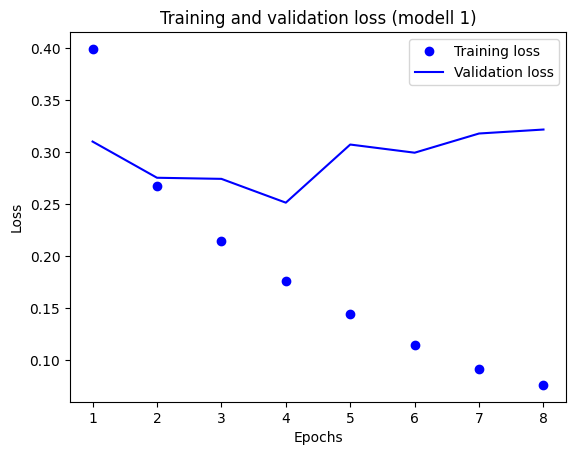

In [ ]:
epoch_es = es.stopped_epoch + 1 # Gör så att plotting fungerar även med early stopping
epochrange = range(1, epoch_es + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 4s 14ms/step - loss: 0.2679 - categorical_accuracy: 0.9072
Test accuracy: 0.907


## Analys
Analysera och jämför dina modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? \
Svar: Testnoggrannheten var ungefär likadan som tidigare, men skillnaderna mellan training- och validation loss samt training- och validation accuracy blev mindre med ett batch normalization layer. Den kör mellan 6 och 8 epochs (varierar lite pga den slumpmässiga datan)

# Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [Se Geron s. 351.., för  "Lerning Rate, Batch Size, and Other Hyperparameters";  s. 379..  "Faster optimizers",]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra). Medan sgd är en mer "ursprunglig" optimerare.
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort färde kan ge instabil träning.

# Övning Del 2c
Byt ut optimeraren från adam till sgd (med regularisering och avbruten träning). Jämför träningsförfarandet mellan de två optimerarna (skillnad i testnoggrannhet, vilken epoch stannade träningen, etc.?).

In [14]:


# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([

# First Convolutional Layer
Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
# Second Convolutional Layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
# Third Convolutional Layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# A hidden Dense layer
Dense(units=36, activation='relu'),

#Batch normalization layer
keras.layers.BatchNormalization(),

# Output layer
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        416       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 36)                451620    
                                                                 
 batch_normalization (Batch  (None, 36)                144       
 Normalization)                                                  
                              

In [15]:
# Din kod för en körning med sgd som optimerare
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',  #sgd as optimizer
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

In [16]:
epochs = 20      ## Number of epoch to run
batch_size = 32  ## Mini batch size
es=keras.callbacks.EarlyStopping('val_loss', patience=4, restore_best_weights = True) #Early stopping callback

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels)),
  callbacks=[es],
)

Epoch 1/20
1500/1500 [==============================] - 11s 6ms/step - loss: 0.4779 - categorical_accuracy: 0.8397 - val_loss: 0.3565 - val_categorical_accuracy: 0.8737
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3436 - categorical_accuracy: 0.8799 - val_loss: 0.3290 - val_categorical_accuracy: 0.8912
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2966 - categorical_accuracy: 0.8951 - val_loss: 0.2997 - val_categorical_accuracy: 0.8988
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2616 - categorical_accuracy: 0.9074 - val_loss: 0.2833 - val_categorical_accuracy: 0.9022
Epoch 5/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2355 - categorical_accuracy: 0.9160 - val_loss: 0.2835 - val_categorical_accuracy: 0.8993
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2134 - categorical_accuracy: 0.9235 - val_loss: 0.2590 - val_categorical_accuracy

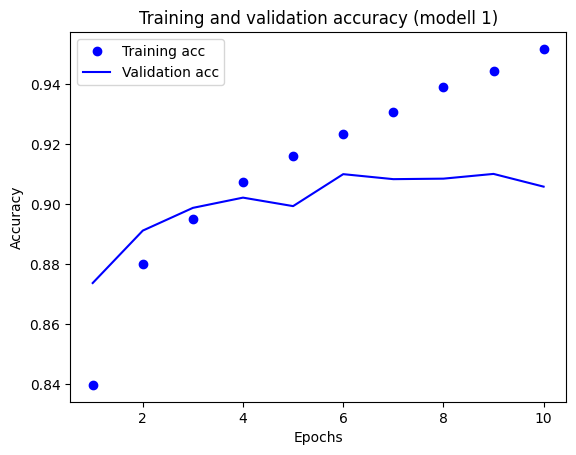

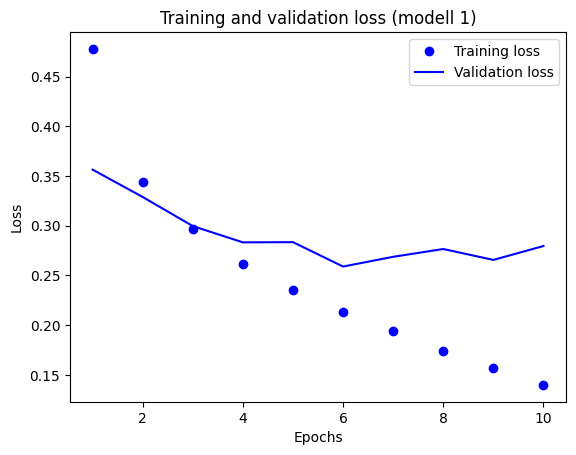

In [17]:
epoch_es = es.stopped_epoch + 1 # Gör så att plotting fungerar även med early stopping
epochrange = range(1, epoch_es + 1)
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.2817 - categorical_accuracy: 0.8991
Test accuracy: 0.899


# Analys
Resultaten för de olika epocherna skiljer sig mer från varandra när sgd används. Noggrannheten och förlusten försämras även lite.

# Del 3 Auto tune
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner (if in colab or kaggle)
if (IS_COLAB or IS_KAGGLE):
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00
Keras Tuner version: 1.4.7


## Exempelmodell (du ska sedan göra en egen!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5,
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

# Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 2 och instrumentera den för att optimeras med Keras Tuner.

In [ ]:
# Min modell
# Fick fram de här värdena.
#conv_1_filter = 256
#conv_1_kernel =   3
#conv_2_filter = 256
#conv_2_kernel =   5
#dense_1_units = 192
#learning_rate = 0.001
#batch_size = 512

def build_model_MyModel(hp):
  model = keras.Sequential([
    # First Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    # Second Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same',
    ),
    # Third Convolutional Layer
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same',
    ),

    # A First Dense Layer
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # Batch normalisation layer
    keras.layers.BatchNormalization(),

    # A Final Dense Layer
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization.

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModel, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

# Help it takes so much time!
Yes, doing a parameter search takes time! Using a T4 this search takes 50 minutes (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

### To run this in Keras 3.0, one needs a KerasTuner of version 1.4.7.dev0 or later
* Earlier version was not working as reported by me here: https://github.com/keras-team/keras-tuner/issues/963



In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 10   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = keras.callbacks.EarlyStopping('val_loss', patience=4, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels,
             epochs=noepochauto,
             validation_data=(val_images, val_labels),
             callbacks=[es])

Trial 20 Complete [00h 13m 19s]
val_accuracy: 0.925083339214325

Best val_accuracy So Far: 0.9259999990463257
Total elapsed time: 02h 38m 19s


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

       conv_1_filter = 256
       conv_1_kernel =   3
       conv_2_filter = 256
       conv_2_kernel =   5
       dense_1_units = 192
       learning_rate = 0.001
          batch_size = 512
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       1638656   
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       1638656   
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 192)               38535360  
                                                               

## Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest):
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel   dense_1_units   learning_rate      batch_size 

          0.925             256               3             256               5             192           0.001             512 
          0.923             192               3             160               5              32           0.001             160 
          0.927             128               3             256               5              96           0.001             352 
          0.920             256               3              96               5              96           0.001             256 
          0.921             224               3             192               5             160           0.001             352 


Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation.

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
94/94 [==============================] - 43s 422ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.2613 - val_accuracy: 0.9280
Epoch 2/30
94/94 [==============================] - 40s 422ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.2913 - val_accuracy: 0.9277
Epoch 3/30
94/94 [==============================] - 42s 444ms/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.2789 - val_accuracy: 0.9307
Epoch 3: early stopping


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.2664 - accuracy: 0.9273
Test accuracy: 0.927


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       1638656   
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       1638656   
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 192)               38535360  
                                                                 
 batch_normalization (Batch  (None, 192)               768       
 Normalization)                                                  
                                                        

#Analys
Gör en komplett analys av de optimerade modellerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden, mha en Bayesiansk sökning, från de värden då fått fram i del 1 och del 2? \
Svar: Flera av värdena var mycket högre än de jag haft innan (t.ex batch size). Ca. 0.927
* Vilka prestanda fick du för de olika fallen? \
Svar: Fick en testnoggrannhet på 0.927 med hjälp av keras tuner. Det högsta jag fick i del 1 och 2 var (ca.) 0.909.
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?) \
Svar: conv_2_filter och conv_1_filter är på maxvärdet.
* Vilka hyperparametrar verkade vara mest betydelsefulla? \
Svar: Conv filter och dense units. Dessa varierade mycket beroende på vilken testomgång det var, och så gjorde resultaten.
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)? \
Svar: conv_1_filter var större än conv_2_filter (baserat på de 5 bästa modellerna). conv_2_kernel var 5 och conv_1_kernel var 3 i alla de 5 bästa modellerna.
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång? \
Svar: Eftersom bilderna som ska klassificeras är slumpade. Därför är det inte samma bilder varje gång man startar en körning. Om man gör 2 "trials" är chanserna större att man får resultat som korrect reftlekterar modellens prestanda.
* Annat som du iaktagit? \
Alla 5 av de bästa modellerna har learning rate 0.001.

# Uppgifter för väl godkänt

Utökning av Del2: Utforska de testfall som missklassificerades för en av dina toppmodeller, vilka typer av plagg verkar vara de som oftast blir fel på, om du tittar på dessa fel förstår du varför nätet har problem med dem?

In [ ]:
# Din kod som utforskar de testfall som missklassificerades

Utökning av Del3: Implementera en undersökning där du även varierar antal lager i din modell, du kan ändra både faltningslager och kompakta lager (eng. dense layers) för att se ifall en ännu bättre modell kan hittas.

Tips: Det är nog bäst att använda en inkrementell/funktionell definition av modellen (där lager läggs till med "model.add(...)" för då blir det lättare att göra en for-slinga runt koden som lägger till ett visst antal lager. Jmf https://keras.io/guides/sequential_model/


```
    filter1=hp.Int('conv_pre_filter', min_value=32, max_value=160, step=32, default=64)
    kernel1=hp.Choice('conv_pre_kernel', values = [3,5], default=3)
    model = Sequential()
    # Add a first convolution layer (with input size)
    model.add(Conv2D(filters=filter1, kernel_size=kernel1, padding='same', activation='relu', input_shape=train_images[0].shape))
    # More fixed layers?
    model.add(....more layer definitions....)
    # Add a varying number of layers
    no_layers = hp.Int('num_layers', 0, 3)
    for i in range(no_layers):
          model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', ...parameters...),
                          kernel_size=hp.Choice(f'conv_{i+1}_kernel', ...parameters....),
                          activation='relu'
                          )
                    )

```



In [ ]:
# Din kod för en keras tuner modell som har antalet lager som en hyperparameter
# och där du söker efter optimerade hyperparametrar för denna modell.